In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton

In [2]:
spreadlist = [0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]
spreaddate = [0.5, 1, 3, 5, 7, 10]

#defining function to initialize parameters
def initializecvaparams():
  global R, cval, dcval, lambda2vallist, vprotlist, vpremlist, spreadlist, spreaddate, spreaddic, yieldtenor, yieldcurve, pspreadlist, pvprotlist, pvpremlist
  R = 0.4
  lambda2vallist = []
  cval = []
  vprotlist = []
  vpremlist = []
  pspreadlist = []
  pvpremlist = []
  pvprotlist = []
  df = pd.read_excel("IRRates.xlsx", header = None)
  yieldtenor = list(df[0])[:np.min(np.where(np.array(list(df[0])) >= spreaddate[-1])) + 1]
  yieldcurve = list(df[1])[:np.min(np.where(np.array(list(df[0])) >= spreaddate[-1])) + 1]
  spreaddic = dict(zip(spreadlist,spreaddate))
  return None

#function to create a discounting function
def disfac(t1, xx):
  global pswitch1
  pswitch1 = 0
  def pswitch1f():
    global pswitch1
    pswitch1 = 1
    return 1
  T = xx
  try:
    # return np.exp(-1* T * 0.039)
    return np.exp(-1 * np.sum(np.array([[(yieldcurve[i - 1] * (([yieldtenor[i] if T >= yieldtenor[i] else T * pswitch1f()][0] - [yieldtenor[i-1] if i!=0 else 0][0]))) if pswitch1 == 0 else 0][0] for i in range(1,len(yieldcurve))])))
  except Exception as e:
    print(e, xx, yieldtenor, jh)

#defining function to calculate survival probability
def surv(T,lambda2val, switch):
  list2 = lambda2vallist[:]
  if switch == +1:
    list2.append(lambda2val)
  def pnt(i, list2):
    return 1
  return np.exp(-1 * np.sum(np.array([list2[i] * (([spreaddate[i] * pnt(i, list2) if T >= spreaddate[i] else T * pnt(i, list2)][0] - [spreaddate[i-1] if i!=0 else 0][0])) for i in range(len(list2))])))

#defining function to calculate the protection leg of the CDS
def Vprot(lambda2val, vprotlist, spreaddic, switch):
    vsum = 0
    if len(vprotlist) == 0:
      vsum = (1 - R) * np.sum(np.array([disfac(0, premtime[i]) * (surv(premtime[i-1], lambda2val, switch) - surv(premtime[i], lambda2val, switch)) for i in range(1, np.min(np.where(premtime >= spreaddate[0])) + 1)]))
    else:
      vsum = vprotlist[-1] + (1 - R) * np.sum(np.array([disfac(0, premtime[i]) * (surv(premtime[i-1], lambda2val, switch) - surv(premtime[i], lambda2val, switch)) for i in range(np.min(np.where(premtime >= spreaddate[len(vprotlist) - 1])) + 1 , np.min(np.where(premtime >= spreaddate[len(vprotlist)])) + 1)]))
    return vsum

#defining function to calculate the premium leg of the CDS
def Vprem(lambda2val, vpremlist, spreaddic, switch):
    psum = 0
    if len(vpremlist) == 0:
      psum = np.sum(np.array([premiumfrequency * disfac(0, premtime[i]) * (surv(premtime[i], lambda2val, switch)) for i in range(1, np.min(np.where(premtime >= spreaddate[0])) + 1)]))
    else:
      psum = (1 / spreadlist[len(vpremlist) - 1]) * vpremlist[-1] + np.sum(np.array([premiumfrequency * disfac(0, premtime[i]) * (surv(premtime[i - 1], lambda2val, switch) + surv(premtime[i], lambda2val, switch)) * 0.5 for i in range(np.min(np.where(premtime >= spreaddate[len(vpremlist) - 1])) + 1, np.min(np.where(premtime >= spreaddate[len(vpremlist)])) + 1)]))
    return psum

#function to calculate lambda value using newton raphson method
def lambda2(lambda2val, vpremlist, spreaddic, vprotlist, switch):
    return (Vprot(lambda2val, vprotlist, spreaddic, switch)/Vprem(lambda2val, vpremlist, spreaddic, switch)) - spreadlist[len(vprotlist)]

#function to boot strap lambda given the lambda value list
def bootstraplambda():
    global lambda2vallist
    for i in list(spreaddic.keys()):
      lambda2val = newton(lambda2, 0.01, args = (vpremlist, spreaddic, vprotlist, +1), maxiter = 10000)
      lambda2vallist.append(lambda2val)
      vpremlist.append(Vprem(lambda2val, vpremlist, spreaddic, -1) * spreadlist[len(vpremlist)])
      vprotlist.append(Vprot(lambda2val, vprotlist, spreaddic, -1))
    lambda2vallist = lambda2vallist
    return lambda2vallist

In [3]:
t1 = 5
T1 = 2
T = 10

In [4]:
t_array = np.arange(T1, T + 1)
initializecvaparams()
premiumfrequency = 0.25
#creating times when exchanges take place
premtime = np.arange(0, spreaddate[-1]+0.25, premiumfrequency)
#bootstrapping lambda values
k = bootstraplambda()

In [5]:
k

[0.0014997188203040247,
 0.0025097811905830476,
 0.004547080794360528,
 0.00894527381564018,
 0.015283227078376082,
 0.023647094963655926]

In [6]:
#finding cumulative hazard rate upto a given time point xx
def cumhazardrate(xx):
  k1 = np.array([0] + (k))
  spreaddate1 = np.array([0] + spreaddate)
  return np.sum(np.array([(k[i-1]) * (spreaddate1[i] - spreaddate1[i - 1]) for i in range(1, np.max(np.where(spreaddate1 <= xx)) + 1)])) + (xx - spreaddate1[np.max(np.where(spreaddate1 <= xx))]) * k1[np.max(np.where(spreaddate1 <= xx))]

In [7]:
for i in [0.0, 0.75068493150685, 1.24931506849315, 3.24931506849315, 5.25205479452055, 7.25205479452055, 10.2547945205479]:
  print(cumhazardrate(i))

0.0
0.0011258163198994606
0.002630476274876568
0.012232567353854473
0.031244158378976195
0.0634081240430481
0.13652234849678027


In [8]:
#survival probability function to create spreads
def psurv(T, lambda2vallist, switch):
  list2 = lambda2vallist[:]
  global pswitch
  pswitch = 0
  def pntswitch(i, list2):
    global pswitch
    pswitch = 1
    return 1
  return np.exp(-1 * np.sum(np.array([[list2[i] * (([spreaddate[i] if T >= spreaddate[i] else T * pntswitch(i, list2)][0] - [spreaddate[i-1] if i!=0 else 0][0])) if pswitch == 0 else 0][0] for i in range(len(list2))])))

# def tsurv(T, i, z, switch):
#   global qswitch
#   qswitch = 0
#   def qntswitch():
#     global qswitch
#     qswitch = 1
#     return 1
#   return [(T - spreaddate[i]) if T >= spreaddate[z - 1] and T <= spreaddate[i] else 0][0]

#protection leg of the CDS used to create spreads
def pvprot(z, pvprotlist, spreaddic, switch):
  def pnt(i, pvprotlist):
    return 1
  if z==0:
    vsum = (1 - R) * np.sum(np.array([disfac(0, premtime[i]) * (psurv(premtime[i-1], lambda2vallist, switch) - psurv(premtime[i], lambda2vallist, switch)) for i in range(1, np.max(np.where(premtime <= spreaddate[0])) + 1)]))
  else:
    vsum = pvprotlist[-1] + (1 - R) * np.sum(np.array([disfac(0, premtime[i]) * (psurv(premtime[i-1], lambda2vallist, switch) - psurv(premtime[i], lambda2vallist, switch)) * pnt(i, pvprotlist) for i in range(np.max(np.where(premtime <= spreaddate[len(pvprotlist) - 1])) + 1 , np.min(np.where(premtime >= spreaddate[len(pvprotlist)])) + 1)]))
  return vsum

#premium leg of the CDS used to create spreads
def pvprem(z, pvpremlist, spreaddic, switch):
  if z==0:
    psum = np.sum(np.array([premiumfrequency * disfac(0, premtime[i]) * ((psurv(premtime[i - 1], lambda2vallist, switch)) + (psurv(premtime[i], lambda2vallist, switch))) * 0.5 for i in range(1, np.max(np.where(premtime <= spreaddate[0])) + 1)]))
  else:
    psum = (1 / pspreadlist[len(pvpremlist) - 1]) * pvpremlist[-1] + np.sum(np.array([premiumfrequency * disfac(0, premtime[i]) * ((psurv(premtime[i-1], lambda2vallist, switch)) + (psurv(premtime[i], lambda2vallist, switch))) * 0.5 for i in range(np.max(np.where(premtime <= spreaddate[len(pvpremlist) - 1])) + 1, np.min(np.where(premtime >= spreaddate[len(pvpremlist)])) + 1)]))
  return psum

#function to create spreads from hazard rates given
def createspreads(l2vl):
  global pspreadlist
  for z in range(len(l2vl)):
    switch = +1
    psprot = pvprot(z, pvprotlist, spreaddic, switch)
    psprem = pvprem(z, pvpremlist, spreaddic, switch)
    ps = psprot / psprem
    pspreadlist.append(ps)
    pvprotlist.append(psprot)
    pvpremlist.append(psprem * pspreadlist[-1])
  pspreadlist = pspreadlist
  return pspreadlist

# Formulaic Spread to lambda sensitivity



In [9]:
premtime

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  ])

In [10]:
#analytical method to find the sensitivity of spread wrt lambda
def dspreadlambda(l2vl1):
  nspreaddate = [0] + spreaddate
  global dspreadl
  dspreadl = np.zeros((len(spreadlist), len(l2vl1)))
  switch = 1
  for k in range(len(spreadlist)):
    for j in range(len(l2vl1)):
      udash = (1 - R) * np.sum(np.array([disfac(0, premtime[i]) * (psurv(premtime[i-1], l2vl1, switch) * ([(-1 * ((premtime[i - 1]) - nspreaddate[j])) if (premtime[i - 1]) > nspreaddate[j] and (premtime[i - 1]) <= nspreaddate[j + 1] else ((-1 * (nspreaddate[j + 1] - nspreaddate[j])) if (premtime[i - 1]) > nspreaddate[j + 1] else 0)][0]) - psurv(premtime[i], l2vl1, switch) * ([(-1 * ((premtime[i]) - nspreaddate[j])) if (premtime[i]) > nspreaddate[j] and (premtime[i]) <= nspreaddate[j + 1] else ((-1 * (nspreaddate[j + 1] - nspreaddate[j])) if (premtime[i]) > nspreaddate[j + 1] else 0)][0])) for i in range(1, np.max(np.where(premtime <= nspreaddate[k+1])) + 1)]))
      vdash = np.sum(np.array([premiumfrequency * disfac(0, premtime[i]) * ((psurv(premtime[i - 1], l2vl1, switch)) * ([(-1 * ((premtime[i - 1]) - nspreaddate[j])) if (premtime[i - 1]) > nspreaddate[j] and (premtime[i - 1]) <= nspreaddate[j + 1] else ((-1 * (nspreaddate[j + 1] - nspreaddate[j])) if (premtime[i - 1]) > nspreaddate[j + 1] else 0)][0])+ (psurv(premtime[i], l2vl1, switch)) * ([(-1 * ((premtime[i]) - nspreaddate[j])) if (premtime[i]) > nspreaddate[j] and (premtime[i]) <= nspreaddate[j + 1] else ((-1 * (nspreaddate[j + 1] - nspreaddate[j])) if (premtime[i]) > nspreaddate[j + 1] else 0)][0])) * 0.5 for i in range(1, np.max(np.where(premtime <= nspreaddate[k+1])) + 1)]))
      u = (1 - R) * np.sum(np.array([disfac(0, premtime[i]) * (psurv(premtime[i-1], l2vl1, switch) - psurv(premtime[i], l2vl1, switch)) for i in range(1, np.max(np.where(premtime <= nspreaddate[k+1])) + 1)]))
      v = np.sum(np.array([premiumfrequency * disfac(0, premtime[i]) * ((psurv(premtime[i - 1], l2vl1, switch)) + (psurv(premtime[i], l2vl1, switch))) * 0.5 for i in range(1, np.max(np.where(premtime <= nspreaddate[k+1])) + 1)]))
      # print(udash, vdash, u, v)
      dspreadl[k,j] = ((udash*v - vdash*u)/(v**2))
  dspreadl = np.transpose(dspreadl)
  return None
dspreadlambda(lambda2vallist)

In [11]:
dspreadl

array([[0.59999998, 0.30289605, 0.10466058, 0.06497413, 0.04805298,
        0.03560083],
       [0.        , 0.29702816, 0.10254577, 0.06359617, 0.04697366,
        0.0347297 ],
       [0.        , 0.        , 0.39225172, 0.24262661, 0.17861921,
        0.13135886],
       [0.        , 0.        , 0.        , 0.2265914 , 0.16588113,
        0.1208781 ],
       [0.        , 0.        , 0.        , 0.        , 0.15488325,
        0.11175985],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.15242736]])

# Go

In [12]:
#comparing actual sprads and spreads created out of hazard rates
print(spreadlist)
createspreads(lambda2vallist)
pspreadlist

[0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]


[0.0008998312816414876,
 0.0011998864210369475,
 0.0021999280202452108,
 0.003399930905761411,
 0.004899926309521903,
 0.007299918583151281]

In [13]:
#getting epe values from excel
df2 = pd.read_excel("EPE.xlsx",header = None)
deltadays = []
deltayears = []
epelist = np.array(df2.iloc[1,1:])
for i in np.array(df2.iloc[0,1:]):
  deltadays.append(i - df2.iloc[3,1])
for i in deltadays:
  deltayears.append(i/365)

# CVA

In [14]:
#calculating CVA using hazard rates and the EPE values taken
def cva(t):
  def pnt6(i):
    # print(i, (psurv(deltayears[i - 1], lambda2vallist, +1) - psurv(deltayears[i], lambda2vallist, +1))/(psurv(deltayears[i - 1], lambda2vallist, +1)) * 1)
    return 1
  global cval
  cval = []
  cval.append((1 - R) * np.sum(np.array([((psurv((deltayears[i - 1] if i!=0 else 0), lambda2vallist, +1) - psurv(deltayears[i], lambda2vallist, +1))/1) * pnt6(i) * epelist[i] for i in range(0,len(deltayears))])))
  return None
cva(0)

In [15]:
print(deltayears[0])
lambda2vallist

0.0027397260273972603


[0.0014997188203040247,
 0.0025097811905830476,
 0.004547080794360528,
 0.00894527381564018,
 0.015283227078376082,
 0.023647094963655926]

# Formulaic sensitivity

In [16]:
#analytical method to find the sensitivity of cva wrt lambda
def dcva(t):
  global dcval
  dcval = []
  nspreaddate = [0] + spreaddate
  for z in range(len(lambda2vallist)):
    dcval.append((1 - R) * np.sum(np.array([(psurv((deltayears[i - 1] if i!=0 else 0), lambda2vallist, +1) * ([(-1 * ((deltayears[i - 1] if i!=0 else 0) - nspreaddate[z])) if (deltayears[i - 1] if i!=0 else 0) > nspreaddate[z] and (deltayears[i - 1] if i!=0 else 0) <= nspreaddate[z + 1] else ((-1 * (nspreaddate[z + 1] - nspreaddate[z])) if (deltayears[i - 1] if i!=0 else 0) > nspreaddate[z + 1] else 0)][0]) - psurv(deltayears[i], lambda2vallist, +1) * ([(-1 * (deltayears[i] - nspreaddate[z])) if deltayears[i] > nspreaddate[z]  and (deltayears[i]) <= nspreaddate[z + 1] else ((-1 * (nspreaddate[z + 1] - nspreaddate[z])) if deltayears[i] > nspreaddate[z + 1] else 0)][0])) * epelist[i] for i in range(1,len(deltayears))])))
  return None
dcva(0)

In [17]:
dcval

[44655397.46156734,
 34436790.94482995,
 91102785.5400323,
 53768291.34866512,
 39393052.6558943,
 8437952.704509526]

# CVA Sensitivity

# Jacobian of spread to hazard rate

In [18]:
#function to bump a list given at the given index
def bump(blist, j, k):
  blist[j] += k
  return None

#function to remember the old lists before bumping
def remember():
  global ocval, oR, olambda2vallist, ovprotlist, ovpremlist, ospreadlist, ospreaddate, ospreaddic, oyieldtenor, oyieldcurve, opspreadlist, opvprotlist, pvpremlist
  ocval = cval[:]
  oR = R
  olambda2vallist = lambda2vallist[:]
  ovprotlist = vprotlist[:]
  ovpremlist = vpremlist[:]
  ospreadlist = spreadlist[:]
  ospreaddate = spreaddate[:]
  ospreaddic = spreaddic
  oyieldtenor = yieldtenor[:]
  oyieldcurve = yieldcurve[:]
  opspreadlist = yieldcurve[:]
  opvprotlist = pvprotlist[:]
  opvpremlist = pvpremlist[:]
  return None

#sensitivity vector calculation
def sensicvalambda(x):
  global cval, lambda2vallist
  m = len(cval)
  n = len(lambda2vallist)
  jmat = np.zeros((n, m))
  for i in range(0, n):
    for j in range(0,m):
      if i == 0 and j == 0:
        remember()
      bump(lambda2vallist, i, x)
      cva(0)
      jmat[i, j] = (cval[j] - ocval[j]) / (lambda2vallist[i] - olambda2vallist[i])
      print(lambda2vallist)
      print(olambda2vallist)
      lambda2vallist = olambda2vallist[:]
      cval = ocval[:]
  return jmat

#calculating the sensitivity of cva with respect to bump in different indices of spread list
def sensicvaspread(x):
  global cval, spreadlist
  m = len(cval)
  n = len(spreadlist)
  jmat = np.zeros((n, m))
  for i in range(0, n):
    for j in range(0,m):
      if i == 0 and j == 0:
        remember()
      bump(spreadlist, i, x)
      initializecvaparams()
      bootstraplambda()
      cva(0)
      jmat[i, j] = (cval[j] - ocval[j]) / (spreadlist[i] - ospreadlist[i])
      print(spreadlist)
      print(ospreadlist)
      spreadlist = ospreadlist[:]
      cval = ocval[:]
  return jmat

#calculating the sensitivity of cva with respect to bump in different indices of lambda list
def sensilambdaspread(x):
  global lambda2vallist, spreadlist
  m = len(lambda2vallist)
  n = len(spreadlist)
  jmat = np.zeros((n, m))
  for i in range(0, n):
    if i!= 0:
      bump(spreadlist, i, x)
      initializecvaparams()
      bootstraplambda()
    for j in range(0,m):
      if i == 0 and j == 0:
        remember()
        bump(spreadlist, i, x)
        initializecvaparams()
        bootstraplambda()
      jmat[i, j] = (lambda2vallist[j] - olambda2vallist[j]) / (spreadlist[i] - ospreadlist[i])
      print(i, j, lambda2vallist[j] - olambda2vallist[j])
      print(lambda2vallist)
      print(olambda2vallist)
      print(spreadlist)
      print(ospreadlist)
    spreadlist = ospreadlist[:]
    cval = ocval[:]
  return jmat

#calculating the sensitivity of each spread with respect to bump in different indices of lambda list
def sensispreadlambda(x):
  global lambda2vallist, spreadlist, pspreadlist
  n = len(lambda2vallist)
  m = len(spreadlist)
  jmat = np.zeros((n, m))
  for i in range(0, n):
    if i != 0:
      bump(lambda2vallist, i, x)
      clambda2vallist = lambda2vallist[:]
      initializecvaparams()
      lambda2vallist = clambda2vallist[:]
      createspreads(lambda2vallist)
    for j in range(0,m):
      if i == 0 and j == 0:
        remember()
        bump(lambda2vallist, i, x)
        clambda2vallist = lambda2vallist[:]
        initializecvaparams()
        lambda2vallist = clambda2vallist[:]
        createspreads(lambda2vallist)
      jmat[i, j] = (pspreadlist[j] - ospreadlist[j]) / (lambda2vallist[i] - olambda2vallist[i])
      print(i, j, pspreadlist[j] - opspreadlist[j])
      print(lambda2vallist)
      print(olambda2vallist)
      print(pspreadlist)
      print(ospreadlist)
    lambda2vallist = olambda2vallist[:]
  return jmat

In [19]:
cval

[1905620.2328818648]

# Parallel lambda bump

In [20]:
lambda2vallist

[0.0014997188203040247,
 0.0025097811905830476,
 0.004547080794360528,
 0.00894527381564018,
 0.015283227078376082,
 0.023647094963655926]

In [21]:
#bumping all the lambda values by equal amount
remember()
for i in range(len(lambda2vallist)):
  lambda2vallist[i] = lambda2vallist[i] + 0.00001
lambda2vallist

[0.0015097188203040247,
 0.0025197811905830476,
 0.004557080794360528,
 0.00895527381564018,
 0.015293227078376081,
 0.023657094963655926]

In [22]:
cva(0)

In [23]:
ocval

[1905620.2328818648]

In [24]:
cval

[1908340.922312976]

In [25]:
#finding the sensitivity of cva to lambda using finite difference method
(cval[0] - ocval[0])/0.00001

272068943.1111328

In [27]:
#finding the sensitivity of cva to lambda using analytical method
(-1 * (1 - R) * np.sum(np.array([((psurv((deltayears[i - 1] if i!=0 else 0), lambda2vallist, +1) * deltayears[i - 1] - psurv(deltayears[i], lambda2vallist, +1) * deltayears[i])/1)  * epelist[i] for i in range(1,len(deltayears))])))

271779894.5807181

# Bucketed lambda bump

In [ ]:
lambda2vallist
# [0.002498937989994155,
#  0.002509779602442351,
#  0.004572461102483108,
#  0.009138478476834414,
#  0.015563088872434155,
#  0.02379101780247523]

[0.0014997188203040247,
 0.0025097811905830476,
 0.004547080794360528,
 0.00894527381564018,
 0.015283227078376082,
 0.023647094963655926]

In [ ]:
#calculating sensitivity of cva wrt lambda for a bump of 0.01
cvalambda0 = sensicvalambda(0.01)

In [ ]:
#calculating sensitivity of cva wrt spread for a bump of 0.01
cvaspread0 = sensicvaspread(0.01)

[0.0109, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]
[0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]
[0.0009, 0.0112, 0.0022, 0.0034, 0.0049, 0.0073]
[0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]
[0.0009, 0.0012, 0.0122, 0.0034, 0.0049, 0.0073]
[0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]
[0.0009, 0.0012, 0.0022, 0.0134, 0.0049, 0.0073]
[0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]
[0.0009, 0.0012, 0.0022, 0.0034, 0.0149, 0.0073]
[0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]
[0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0173]
[0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]


In [ ]:
#calculating sensitivity of each spread wrt lambda for a bump of 0.01
spreadlambda0 = sensispreadlambda(0.01)

0 0 -0.032720773460199436
[0.011499718820304025, 0.0025097811905830476, 0.004547080794360528, 0.00894527381564018, 0.015283227078376082, 0.023647094963655926]
[0.0014997188203040247, 0.0025097811905830476, 0.004547080794360528, 0.00894527381564018, 0.015283227078376082, 0.023647094963655926]
[0.0068998265398005606, 0.004232606073803076, 0.003248701977177604, 0.004051126529418685, 0.005381565964887117, 0.007656767903852073]
[0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]
0 1 -0.035352593926196926
[0.011499718820304025, 0.0025097811905830476, 0.004547080794360528, 0.00894527381564018, 0.015283227078376082, 0.023647094963655926]
[0.0014997188203040247, 0.0025097811905830476, 0.004547080794360528, 0.00894527381564018, 0.015283227078376082, 0.023647094963655926]
[0.0068998265398005606, 0.004232606073803076, 0.003248701977177604, 0.004051126529418685, 0.005381565964887117, 0.007656767903852073]
[0.0009, 0.0012, 0.0022, 0.0034, 0.0049, 0.0073]
0 2 -0.036325298022822396
[0.011499718820304025,

In [ ]:
#sensitivity of cva spread wrt lambda by anaytical method
dspreadl

array([[0.59999998, 0.30289605, 0.10466058, 0.06497413, 0.04805298,
        0.03560083],
       [0.        , 0.29702816, 0.10254577, 0.06359617, 0.04697366,
        0.0347297 ],
       [0.        , 0.        , 0.39225172, 0.24262661, 0.17861921,
        0.13135886],
       [0.        , 0.        , 0.        , 0.2265914 , 0.16588113,
        0.1208781 ],
       [0.        , 0.        , 0.        , 0.        , 0.15488325,
        0.11175985],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.15242736]])

In [ ]:
#taking inverse of dspreadl
invj0 = np.linalg.inv(dspreadl)

In [ ]:
#checking the accuracy of the inverse
np.matmul(spreadlambda0,invj0)

array([[ 1.00000000e+00, -8.65100264e-17,  1.14952360e-18,
         2.01047052e-17,  6.33945196e-18, -1.39528448e-18],
       [-1.72379491e-21,  1.00000000e+00, -3.97720330e-17,
        -1.88502412e-17,  1.61527487e-17, -2.30018856e-17],
       [ 1.75365910e-21,  1.51672733e-21,  1.00000000e+00,
         9.15693976e-17, -4.40518686e-17,  7.43514282e-17],
       [-3.44400591e-21, -1.30862672e-21,  1.18481684e-21,
         1.00000000e+00,  8.24139255e-18,  2.38095342e-17],
       [-6.82009819e-21, -2.36840535e-21,  1.38657182e-21,
        -1.16957813e-21,  1.00000000e+00,  1.39202538e-17],
       [-1.61681548e-21, -8.81934341e-22,  1.51374240e-21,
         1.78002906e-22,  3.02235793e-21,  1.00000000e+00]])

In [ ]:
cvaspread0 * 0.0001

array([[ 1614.86574776],
       [ 3541.87064323],
       [ 8411.05650438],
       [ 5075.5829076 ],
       [21293.8755345 ],
       [ 5674.41655017]])

In [ ]:
#dot product between inverse of spread wrt lambda sensitivity matrix and analytical sensitivity of cva wrt to lambda
np.dot(invj0, dcval)*0.0001

array([ 1580.31599177,  3545.26728919,  8466.14630033,  5080.76594217,
       21439.59319323,  5535.72050816])

In [ ]:
#dot product between inverse of spread wrt lambda sensitivity matrix and finite difference sensitivity of cva wrt to lambda
np.dot(invj0, cvalambda0) * 0.0001

array([[ 1616.5683663 ],
       [ 3587.92383112],
       [ 8343.37651679],
       [ 4966.32317507],
       [21354.68408434],
       [ 5557.04167815]])

# Graphing

In [ ]:
spreaddate

[0.5, 1, 3, 5, 7, 10]

In [ ]:
tb = np.arange(0,10,0.001)
gg=[]
for i in range(len(tb)):
  # print(tb[i],np.min(np.where(spreaddate>=tb[i])))
  gg.append(lambda2vallist[np.min(np.where(spreaddate>=tb[i]))])


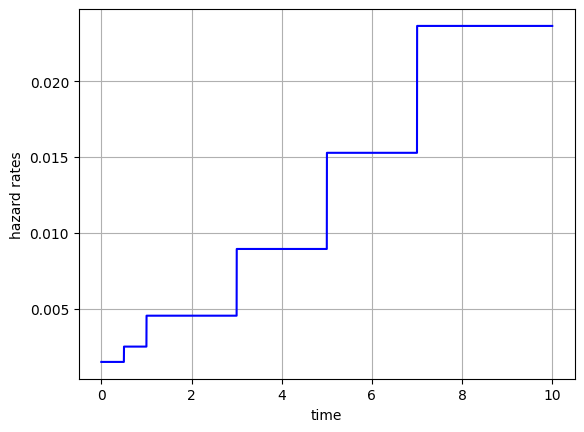

In [ ]:
#hazard rate graph over the lifetime of the interest rate swap
plt.figure(2)
plt.grid()
plt.xlabel("time")
plt.ylabel("hazard rates")
# eSM_P = lambda t: S_0 * np.exp(mu * t) / M(t)
# plt.plot(time, eSM_P(time), 'r--')
plt.plot(tb, gg, 'blue')